<h1><center>Time Series Forecasting for Web Traffic 

The goal of this notebook is to do a comparison of few models when you have one Time Series. The plan of the notebook is:
1. To see if language influences Page Total View 
2. Checking the stationarity    
3. Making the time series stationery   
    3.1. Log transformation  
    3.2. Remove trend and seasonality with decomposition  
    3.3. Remove trend and seasonality with differencing  
4. Plot the autocorreltaion and partial auto correlation functions

**Applying Models:** 
    
5. Auto Regressive (AR) Model  
6. Moving Average (MA) Model  
7. ARIMA MODEL  

In [20]:
import pandas as pd
import numpy as np
import pylab as p
from IPython.display import display
import matplotlib.pyplot as plt
from collections import Counter
import re

import warnings
warnings.filterwarnings('ignore')

train = pd.read_csv(r'C:\Users\Pundeer\Desktop\Data Science\Kaggle\Web traffic time series forecast\train_1.csv').fillna(0)
display(train.head())

,Page,2015-07-01,2015-07-02,2015-07-03,2015-07-04,2015-07-05,2015-07-06,2015-07-07,2015-07-08,2015-07-09,...,2016-12-22,2016-12-23,2016-12-24,2016-12-25,2016-12-26,2016-12-27,2016-12-28,2016-12-29,2016-12-30,2016-12-31
0,2NE1_zh.wikipedia.org_all-access_spider,18.0,11.0,5.0,13.0,14.0,9.0,9.0,22.0,26.0,...,32.0,63.0,15.0,26.0,14.0,20.0,22.0,19.0,18.0,20.0
1,2PM_zh.wikipedia.org_all-access_spider,11.0,14.0,15.0,18.0,11.0,13.0,22.0,11.0,10.0,...,17.0,42.0,28.0,15.0,9.0,30.0,52.0,45.0,26.0,20.0
2,3C_zh.wikipedia.org_all-access_spider,1.0,0.0,1.0,1.0,0.0,4.0,0.0,3.0,4.0,...,3.0,1.0,1.0,7.0,4.0,4.0,6.0,3.0,4.0,17.0
3,4minute_zh.wikipedia.org_all-access_spider,35.0,13.0,10.0,94.0,4.0,26.0,14.0,9.0,11.0,...,32.0,10.0,26.0,27.0,16.0,11.0,17.0,19.0,10.0,11.0
4,52_Hz_I_Love_You_zh.wikipedia.org_all-access_s...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,48.0,9.0,25.0,13.0,3.0,11.0,27.0,13.0,36.0,10.0


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 145063 entries, 0 to 145062
Columns: 551 entries, Page to 2016-12-31
dtypes: float64(550), object(1)
memory usage: 609.8+ MB


### 1. Language Influences Page Total View

In [6]:
def lang(Page):
    val = re.search('[a-z][a-z].wikipedia.org',Page)
    if val:
        return val[0][0:2]             
    # no_lang for media files ; wikimedia.org
    return 'no_lang'

train['language'] = train.Page.map(lang)

# Article Count 
print("\nArticle count as per Language : \n", Counter(train.language))


Article count as per Language : 
 Counter({'en': 24108, 'ja': 20431, 'de': 18547, 'no_lang': 17855, 'fr': 17802, 'zh': 17229, 'ru': 15022, 'es': 14069})


In [8]:
language_set = {}
language_set['en'] = train[train.language == 'en'].iloc[:, 0:-1]
language_set['ja'] = train[train.language == 'ja'].iloc[:, 0:-1]
language_set['de'] = train[train.language == 'de'].iloc[:, 0:-1]
language_set['fr'] = train[train.language == 'fr'].iloc[:, 0:-1]
language_set['ru'] = train[train.language == 'ru'].iloc[:, 0:-1]
language_set['es'] = train[train.language == 'es'].iloc[:, 0:-1]
language_set['no_lang'] = train[train.language == 'no_lang'].iloc[:, 0:-1]

In [11]:
total_view = {} 
for key in language_set:
    total_view[key] = language_set[key].iloc[:, 1:].sum(axis=0) / language_set[key].shape[0]

for key in language_set:
    print("KEY : ", key)
    print("Total_Value KEY : \n", total_view[key])

KEY :  en
Total_Value KEY : 
 2015-07-01    3513.862203
2015-07-02    3502.511407
2015-07-03    3325.357889
2015-07-04    3462.054256
2015-07-05    3575.520035
                 ...     
2016-12-27    6040.680728
2016-12-28    5860.227559
2016-12-29    6245.127510
2016-12-30    5201.783018
2016-12-31    5127.916418
Length: 550, dtype: float64
KEY :  ja
Total_Value KEY : 
 2015-07-01     580.647056
2015-07-02     666.672801
2015-07-03     602.289805
2015-07-04     756.509177
2015-07-05     725.720914
                 ...     
2016-12-27     789.158680
2016-12-28     790.500465
2016-12-29     865.483236
2016-12-30     952.018354
2016-12-31    1197.239440
Length: 550, dtype: float64
KEY :  de
Total_Value KEY : 
 2015-07-01     714.968405
2015-07-02     705.229741
2015-07-03     676.877231
2015-07-04     621.145145
2015-07-05     722.076185
                 ...     
2016-12-27    1085.095379
2016-12-28    1032.640804
2016-12-29     994.657141
2016-12-30     949.265649
2016-12-31     893.013

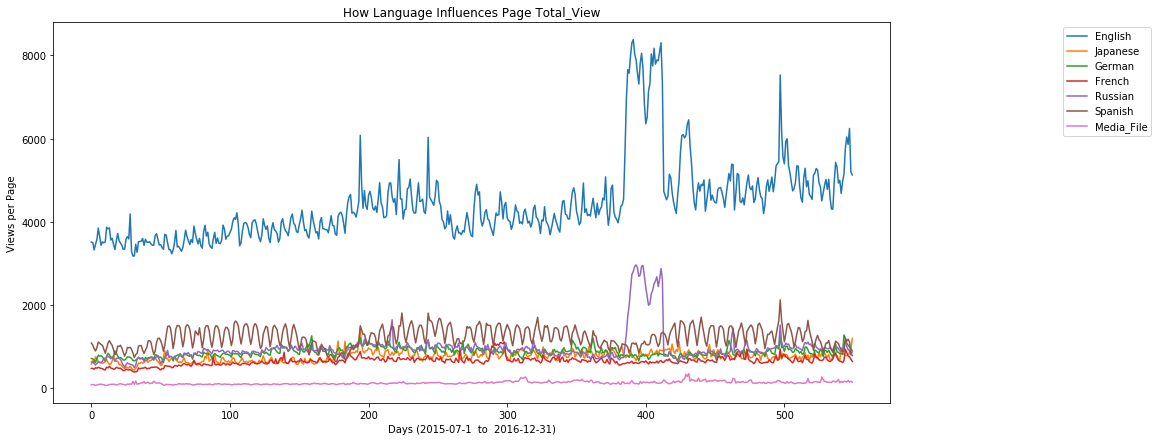

In [14]:
days = [r for r in range(total_view['en'].shape[0])]

plt.figure(figsize=(15, 7))
labels={'ja':'Japanese','de':'German','en' : 'English','no_lang':'Media_File','fr':'French','zh':'Chinese',
        'ru':'Russian','es':'Spanish'}

for key in total_view:
    plt.plot(days, total_view[key], label = labels[key])
    
plot.ylabel('Views per Page')
plot.xlabel('Days (2015-07-1  to  2016-12-31)')
plot.title('How Language Influences Page Total_View')
plot.legend(loc = 'upper left', bbox_to_anchor = (1.2, 1))
plot.show()

### 2. Checking the stationarity
1.Plotting rolling statistics  
2.Dickey-Fuller test

Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary.

### Augmented Dicky Fuller Test
The Augmented Dicky Fuller test determines how strongly a time series is defined by a trend.

1. Null Hypothesis (H0): The time series is not stationary. &emsp;  **p value > 0.05**
2. Alternative Hypothesis (H1): The time series is stationary.  &emsp;  **p value <= 0.05**

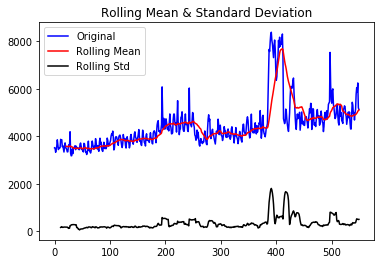

ADF Stastistic: -2.247284
p-value: 0.189534
The graph is non stationery
Critical values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [18]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(x):
    #Determing rolling statistics
    rolmean = x.rolling(window=22,center=False).mean()
    rolstd = x.rolling(window=12,center=False).std()
    
    #Plot rolling statistics:
    org = plt.plot(x.values, color='blue',label='Original')
    mean = plt.plot(rolmean.values, color='red', label='Rolling Mean')
    std = plt.plot(rolstd.values, color='black', label = 'Rolling Std')
    
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey Fuller test    
    result = adfuller(x)
    print('ADF Stastistic: %f'%result[0])
    print('p-value: %f'%result[1])
    
    #print(result[4])
    pvalue = result[1]
    for key,value in result[4].items():
        if result[0]>value:
            print("The graph is non stationery")
            break
        else:
            print("The graph is stationery")
            break;
            
    print('Critical values:')
    for key,value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
test_stationarity(total_view['en'])

### 3. Making the time series stationery
Estimitating and eliminating trend and seasonality  

**3.1 Log transformation**

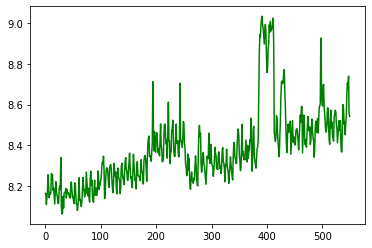

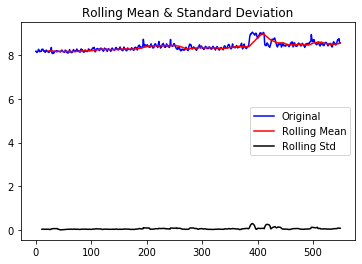

ADF Stastistic: -2.032439
p-value: 0.272533
The graph is non stationery
Critical values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [21]:
log_ts = np.log(total_view['en'])
plt.plot(log_ts.values, color = "green")
plt.show()

test_stationarity(log_ts)

**3.2 Removing trend and seasonality with decomposition**

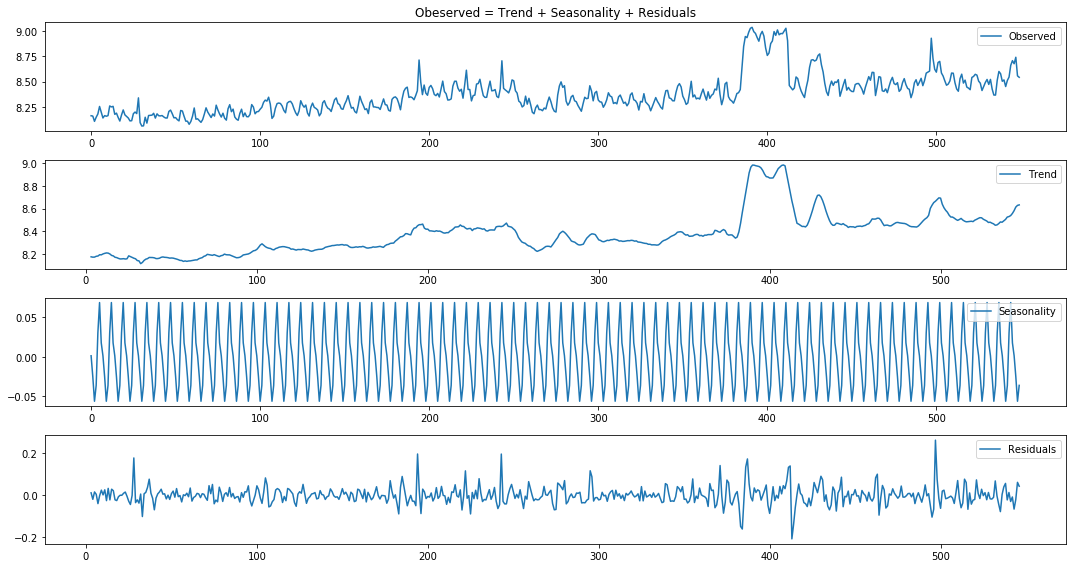

In [27]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(log_ts.values, model='additive',freq = 7)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize = (15,8))

plt.subplot(411)
plt.title('Observed = Trend + Seasonality + Residuals')
plt.plot(log_ts.values, label='Observed')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

**3.3 Removing trend and seasonality with differencing**

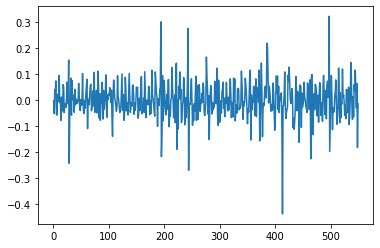

In [29]:
log_diff = log_ts - log_ts.shift()
plot.plot(log_diff.values)
plot.show()

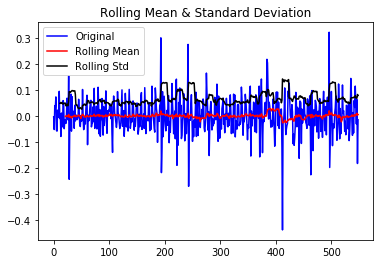

ADF Stastistic: -8.154260
p-value: 0.000000
The graph is stationery
Critical values:
	1%: -3.443
	5%: -2.867
	10%: -2.570


In [36]:
log_diff.dropna(inplace=True)
test_stationarity(log_diff)

ADF statistic is much less than critical value at 1%. So there is 99% confidence interval that our graph is now stationery. Now we can apply the ARIMA model

### 4. Plot the autocorreltaion and partial auto correlation functions

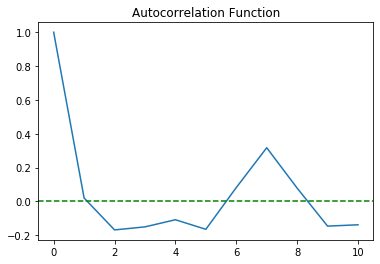

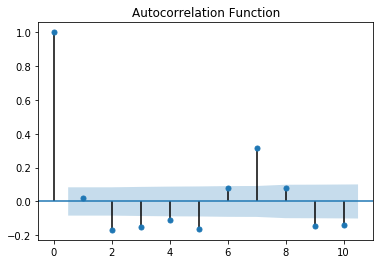

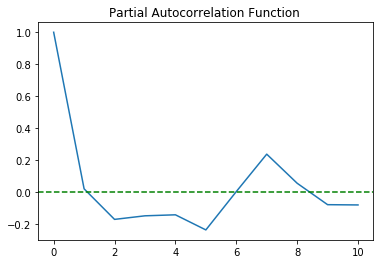

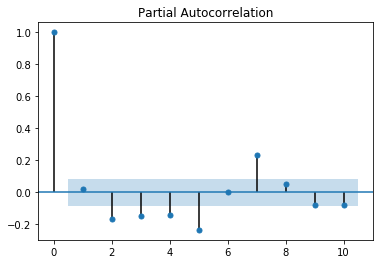

In [59]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

lag_acf = acf(log_diff, nlags=10)
lag_pacf = pacf(log_diff, nlags=10, method='ols')

#Plot ACF: 
plt.subplot(1,1,1)
plt.plot(lag_acf)

plt.axhline(y=0,linestyle='--',color='g')
plt.title('Autocorrelation Function')
plot_acf(log_diff, lags=10, title='Autocorrelation Function')
plt.show()

#Plot PACF:
plt.subplot(1,1,1)
plt.plot(lag_pacf)

plt.axhline(y=0,linestyle='--',color='green')
plt.title('Partial Autocorrelation Function ')
plot_pacf(log_diff, lags=10, title='Partial Autocorrelation')
#plt.tight_layout()
plt.show()

### 5. Auto Regressive (AR) Model

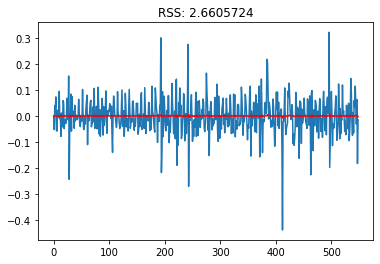

In [62]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(log_ts.values, order=(1,1,0))  
results_AR = model.fit(disp=-1)  
plt.plot(log_diff.values)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.7f'% sum((results_AR.fittedvalues - log_diff.values)**2))
plt.show()

### 6. Moving Average (MA) Model

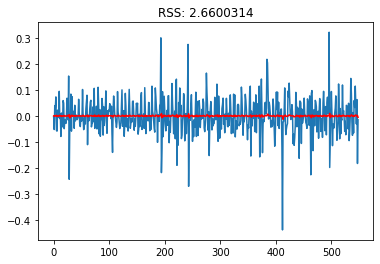

In [63]:
# follow error
model = ARIMA(log_ts.values, order=(0,1,1))  
results_MA = model.fit(disp=-1)  
plt.plot(log_diff.values)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.7f'% sum((results_MA.fittedvalues - log_diff.values)**2))
plt.show()

### 7. ARIMA MODEL

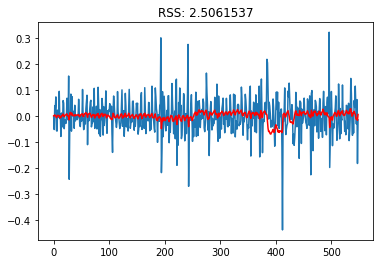

In [65]:
model = ARIMA(log_ts.values, order=(1,1,1))  
results_ARIMA = model.fit(disp=-1)  
plt.plot(log_diff.values)
plt.plot(results_ARIMA.fittedvalues, color='red')
plt.title('RSS: %.7f'% sum((results_ARIMA.fittedvalues-log_diff.values)**2))
plt.show()

In [66]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                  549
Model:                 ARIMA(1, 1, 1)   Log Likelihood                 699.951
Method:                       css-mle   S.D. of innovations              0.067
Date:                Wed, 21 Oct 2020   AIC                          -1391.902
Time:                        00:11:28   BIC                          -1374.670
Sample:                             1   HQIC                         -1385.167
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      5.830      0.000       0.001       0.001
ar.L1.D.y      0.8753      0.021     41.812      0.000       0.834       0.916
ma.L1.D.y     -1.0000      0.005   -182.567      0.000      -1.011      -0.989
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.1425           +0.0000j            1.1425            0.0000
MA.1            1.0000           +0.0000j            1.0000            0.0000
-----------------------------------------------------------------------------
"""

In [69]:
size = int(len(log_ts)-100)
train_arima, test_arima = log_ts[0:size], log_ts[size:len(log_ts)]

history = [x for x in train_arima]
predictions = list()
originals = list()
error_list = list()

for t in range(len(test_arima)):
    model = ARIMA(history, order=(1, 1, 1))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()  
    pred_value = output[0]
    
    original_value = test_arima[t]
    history.append(original_value)
   
    pred_value = np.exp(pred_value)
    original_value = np.exp(original_value)
    
    error = ((abs(pred_value - original_value)) / original_value) * 100
    error_list.append(error)
    
    predictions.append(float(pred_value))
    originals.append(float(original_value))
    
print('\n Means Error in Predicting Test Case Articles : %f ' % (sum(error_list)/float(len(error_list))), '%')


 Means Error in Predicting Test Case Articles : 5.420565  %


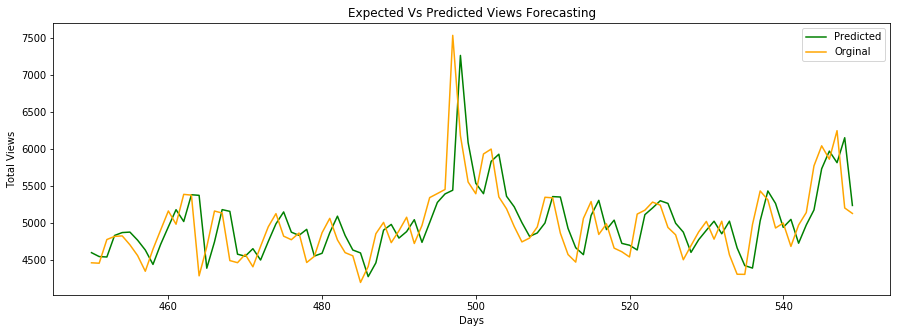

In [73]:
plt.figure(figsize=(15, 5))
test_day = [t+450 for t in range(len(test_arima))]
labels={'Orginal','Predicted'}
plt.plot(test_day, predictions, color= 'green')
plt.plot(test_day, originals, color = 'orange')
plt.title('Expected Vs Predicted Views Forecasting')
plt.xlabel('Days')
plt.ylabel('Total Views')
plt.legend(labels)
plt.show()

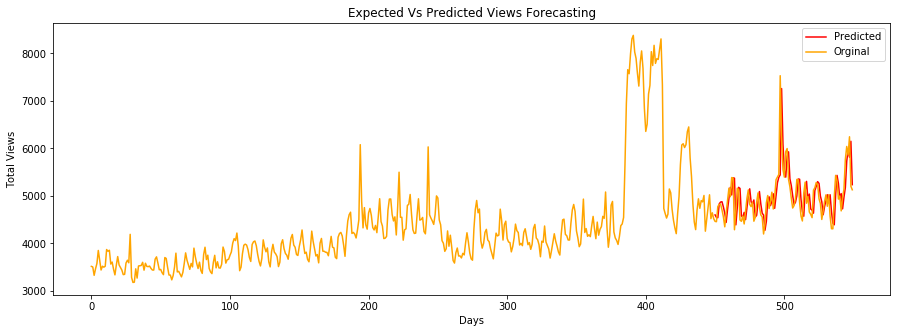

In [74]:
plt.figure(figsize=(15, 5))
test_day = [t+450 for t in range(len(test_arima))]
labels={'Orginal','Predicted'}
plt.plot(test_day, predictions, color= 'red')
plt.plot(days, total_view['en'], color = 'orange')
plt.title('Expected Vs Predicted Views Forecasting')
plt.xlabel('Days')
plt.ylabel('Total Views')
plt.legend(labels)
plt.show()